In [2]:
from diffusers import StableDiffusionPipeline
from transformers import CLIPModel, CLIPProcessor
import transformer_lens
import torch

/Users/josephmiller/Documents/clip-interp/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip = transformer_lens.HookedTransformer.from_pretrained(
    "clip",
    center_unembed=False,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
    device=device,
)

# make sure you're logged in with `huggingface-cli login`
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("mps")

# First-time "warmup" pass (see explanation above)
_ = pipe("warmup", num_inference_steps=1)

Loaded pretrained model clip into HookedTransformer
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 185588.67it/s]
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/Users/josephmiller/Documents/clip-interp/venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
100%|██████████| 1/1 [00:02<00:00,  2.13s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


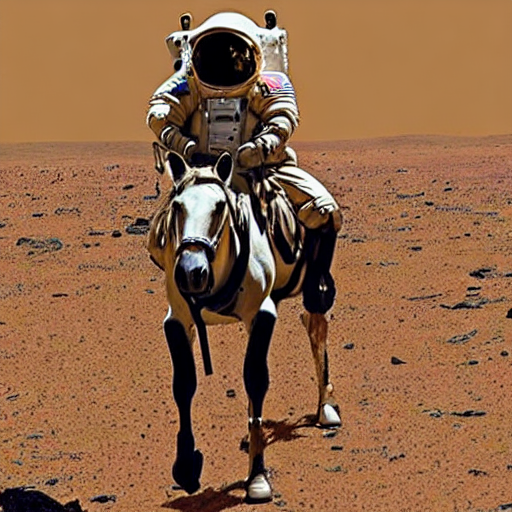

In [8]:
prompt = "a photo of an astronaut riding a horse on mars"
torch.manual_seed(0)
pipe(prompt).images[0]

tensor([[49406,   320,  1125,   539,   550, 18376,  6765,   320,  4558,   525,
          7496, 49407]])
['<|startoftext|>', 'a', 'photo', 'of', 'an', 'astronaut', 'riding', 'a', 'horse', 'on', 'mars', '<|endoftext|>']


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


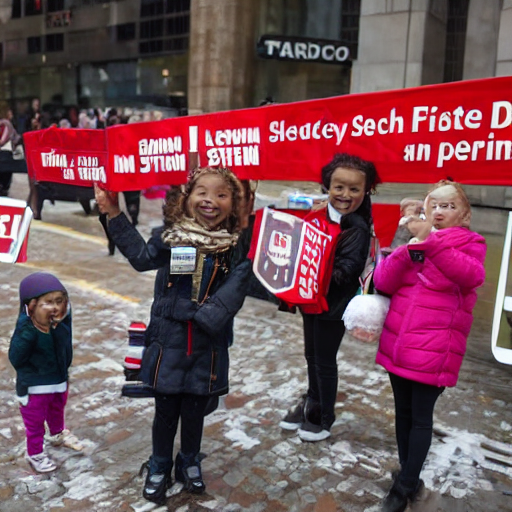

In [9]:
tokens = clip.to_tokens(prompt, prepend_bos=False).to(device=device)
print(tokens)
print(clip.to_str_tokens(prompt, prepend_bos=False))

original_logits, cache = clip.run_with_cache(tokens)
pipe(prompt_embeds=original_logits).images[0]

In [17]:
# print(cache.keys)
print(cache["hook_embed"])
print(cache["hook_pos_embed"])
print(cache["blocks.0.hook_resid_pre"])
print(cache["blocks.0.hook_resid_post"])

tensor([[[ 0.0005,  0.0026, -0.0003,  ..., -0.0024, -0.0003,  0.0013],
         [ 0.0014, -0.0011, -0.0125,  ..., -0.0124,  0.0121,  0.0081],
         [ 0.0093, -0.0199,  0.0086,  ..., -0.0045, -0.0166,  0.0120],
         ...,
         [ 0.0004, -0.0055,  0.0035,  ...,  0.0109, -0.0126, -0.0169],
         [-0.0200, -0.0273,  0.0017,  ..., -0.0278,  0.0034,  0.0079],
         [ 0.0006,  0.0072, -0.0017,  ..., -0.0021,  0.0003,  0.0047]]])
tensor([[[ 1.0066e-03,  1.4321e-03, -3.6904e-04,  ..., -1.8800e-03,
           2.0277e-04,  9.3024e-04],
         [ 4.0781e-03,  2.7198e-03,  4.5543e-05,  ...,  8.7713e-04,
           1.3347e-03, -1.3530e-03],
         [ 1.6428e-03,  5.4609e-04, -1.4347e-03,  ..., -3.1363e-03,
          -1.1122e-03,  2.3653e-03],
         ...,
         [ 1.0699e-03, -1.0689e-03,  6.2368e-04,  ...,  2.0969e-03,
           2.1054e-04,  2.8356e-03],
         [ 1.3887e-04, -8.2799e-04,  1.1758e-04,  ...,  1.9080e-03,
          -4.4235e-04,  1.4601e-03],
         [-2.5801e-

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")


In [21]:
tokens = processor.tokenizer(prompt, return_tensors="pt").to(device=device)
print('tokens', tokens)
print(tokens.input_ids.shape)
print(tokens.attention_mask.shape)
def print_output(module, input, output):
    print("BLLL INPUT")
    print(input)
    # print("INPUT 1")
    # print(input[1])
    print("OUTPUT")
    print(output)

handle = model.text_model.encoder.register_forward_hook(print_output)
# handle = model.text_model.encoder.layers[0].register_forward_hook(print_output)
try:
    with torch.inference_mode():
        logits = model.text_model(**tokens).last_hidden_state
finally:
    handle.remove()
print(logits.shape)

tokens {'input_ids': tensor([[49406,   320,  1125,   539,   550, 18376,  6765,   320,  4558,   525,
          7496, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
torch.Size([1, 12])
torch.Size([1, 12])
INPUT


IndexError: tuple index out of range

In [7]:
print(original_logits)
print(logits)

tensor([[[-0.3867,  0.0357, -0.0368,  ..., -0.4888, -0.2935,  0.0751],
         [-0.6449,  1.7873,  0.6049,  ...,  0.9153,  0.2146,  0.9041],
         [-0.9761,  0.8250,  1.0768,  ..., -0.3339, -0.2905,  0.4197],
         ...,
         [-1.6396,  1.3580,  2.0060,  ...,  0.5414,  0.2226, -0.3856],
         [-0.9565,  0.4417,  1.1839,  ...,  0.6677,  0.6681, -0.5107],
         [-0.7449,  0.8310,  1.3205,  ...,  0.9635,  0.1606, -0.4969]]],
       grad_fn=<AddBackward0>)
tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 1.1565,  0.1318,  0.7895,  ..., -2.1024, -1.1519, -0.3311],
         ...,
         [-2.2087, -0.0796,  0.3359,  ...,  1.1501, -0.4306, -0.2275],
         [-1.2404, -1.4591,  2.0436,  ..., -1.6899, -0.4091,  0.6972],
         [-2.6286,  0.3623,  0.2938,  ...,  0.0308, -0.7315, -0.1319]]])


100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


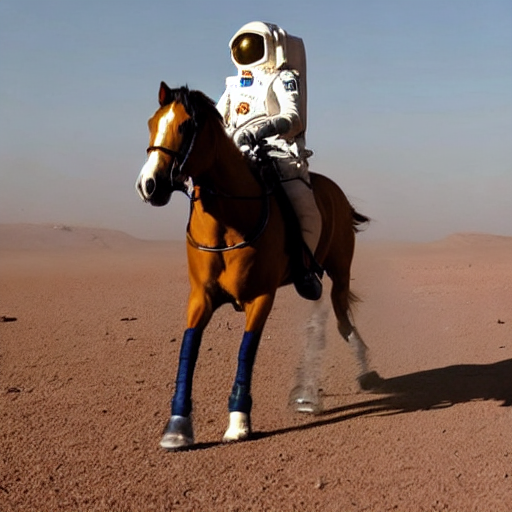

In [8]:
pipe(prompt_embeds=logits).images[0]